In [22]:
import os
import pickle
from pathlib import Path
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------- #
# Configuración y paths         #
# ----------------------------- #
SEED = 42
np.random.seed(SEED)

BASE_DIR = Path(r"C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\CONDOR_EAS-Reconstruction")
CACHE_FILE = BASE_DIR / "processed_all_data.pkl"

ARTIFACTS_DIR = Path(r"C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\CONDOR_EAS-Reconstruction\pipeline_artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

ENERGY_FILTER = ("3E2", "5E2", "8E2")
ANGLE_MAX = 40.0
MIN_TOTAL_PARTICLES = 30

LABEL_MAP = {0: "Proton", 1: "Photon"}
PARTICLE_COLORS = {"Photon": "orange", "Proton": "royalblue"}

sns.set_context("poster")
sns.set_style("ticks")

In [23]:
# ----------------------------- #
# Carga del dataset procesado   #
# ----------------------------- #
def load_dataset_from_cache(cache_path: Path) -> pd.DataFrame:
    if not cache_path.exists():
        raise FileNotFoundError(
            f"No se encontró {cache_path}. Regenera el pickle antes de continuar."
        )
    with cache_path.open("rb") as fh:
        data = pickle.load(fh)
    if isinstance(data, pd.DataFrame):
        df = data.copy()
    elif isinstance(data, dict):
        df = pd.DataFrame(data)
    else:
        raise ValueError("Formato de caché no soportado.")
    required_cols = {"shower_data", "angle", "label", "energy", "total_particles", "max_time"}
    if not required_cols.issubset(df.columns):
        raise ValueError("El pickle no contiene todas las columnas necesarias.")
    return df.reset_index(drop=True)

df_raw = load_dataset_from_cache(CACHE_FILE)

df_filtered = df_raw[
    (df_raw["energy"].isin(ENERGY_FILTER)) &
    (df_raw["angle"] <= ANGLE_MAX) &
    (df_raw["total_particles"] >= MIN_TOTAL_PARTICLES)
].reset_index(drop=True)

print(f"Eventos disponibles (raw): {len(df_raw)}")
print(f"Eventos tras filtrado: {len(df_filtered)}")

df_filtered["particle"] = df_filtered["label"].map(LABEL_MAP)
df_filtered["energy_GeV"] = df_filtered["energy"].str.replace("E", "e").astype(float)

Eventos disponibles (raw): 271357
Eventos tras filtrado: 96988


In [24]:
# ----------------------------- #
# Catálogo de detectores        #
# ----------------------------- #
def build_detector_catalog(df: pd.DataFrame) -> pd.DataFrame:
    positions = []
    for seq in df["shower_data"]:
        arr = np.asarray(seq, dtype=np.float32)
        if arr.size == 0:
            continue
        positions.append(arr[:, [0, 5, 6]])
    if not positions:
        return pd.DataFrame(columns=["detector_id", "x_center", "y_center"])
    catalog = (
        pd.DataFrame(np.vstack(positions), columns=["detector_id", "x_center", "y_center"])
        .drop_duplicates(subset=["detector_id"])
        .sort_values("detector_id")
        .reset_index(drop=True)
    )
    catalog["detector_id"] = catalog["detector_id"].astype(int)
    return catalog

detector_catalog = build_detector_catalog(df_filtered)
detector_catalog.to_csv(ARTIFACTS_DIR / "detector_catalog.csv", index=False)

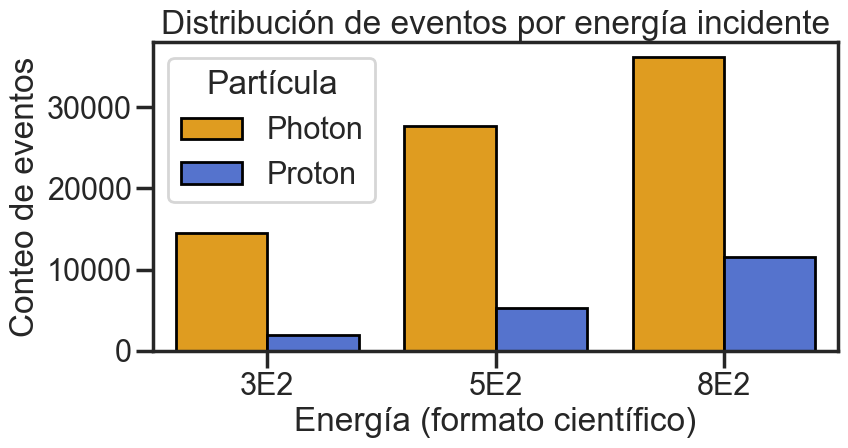

In [25]:
# ----------------------------- #
# Distribución por energía      #
# ----------------------------- #
plt.figure(figsize=(9, 5))
sns.countplot(
    data=df_filtered,
    x="energy",
    hue="particle",
    order=sorted(df_filtered["energy"].unique(), key=lambda x: float(x.replace("E", "e"))),
    palette=PARTICLE_COLORS,
    edgecolor="black",
)
plt.title("Distribución de eventos por energía incidente")
plt.xlabel("Energía (formato científico)")
plt.ylabel("Conteo de eventos")
plt.legend(title="Partícula")
plt.tight_layout()
plt.show()

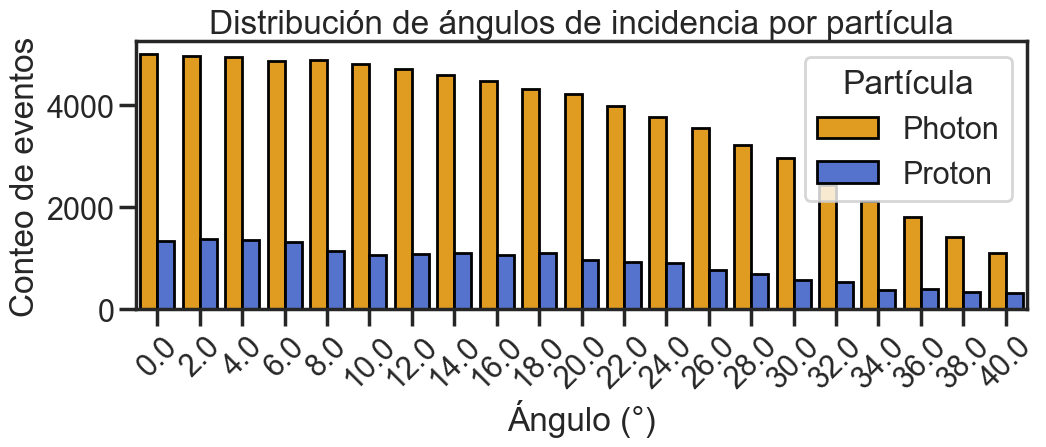

In [26]:
# ----------------------------- #
# Distribución angular          #
# ----------------------------- #
plt.figure(figsize=(11, 5))
sns.countplot(
    data=df_filtered,
    x="angle",
    hue="particle",
    palette=PARTICLE_COLORS,
    edgecolor="black",
)
plt.title("Distribución de ángulos de incidencia por partícula")
plt.xlabel("Ángulo (°)")
plt.ylabel("Conteo de eventos")
plt.legend(title="Partícula")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

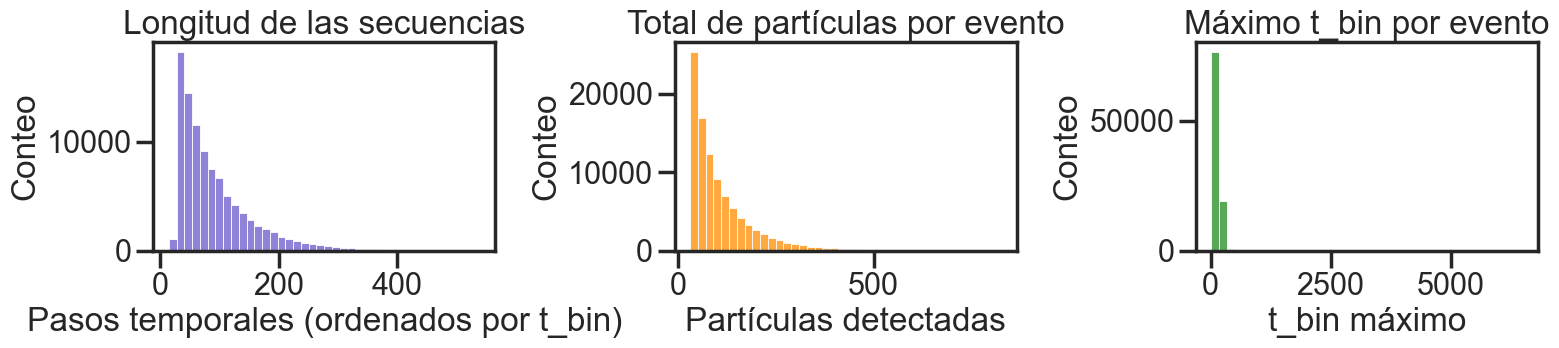

Resumen de longitud de secuencias (pasos):
  Media: 91.47928609724914
  Percentiles (50/90/95/99): [ 71. 179. 223. 319.]


In [27]:
# ----------------------------- #
# Estadísticas de secuencias    #
# ----------------------------- #
def sequence_length(seq: np.ndarray) -> int:
    arr = np.asarray(seq)
    return arr.shape[0] if arr.ndim == 2 else 0

seq_lengths = df_filtered["shower_data"].apply(sequence_length)
tot_particles = df_filtered["total_particles"]
max_times = df_filtered["max_time"]

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
sns.histplot(seq_lengths, bins=40, color="slateblue", ax=axes[0])
axes[0].set_title("Longitud de las secuencias")
axes[0].set_xlabel("Pasos temporales (ordenados por t_bin)")
axes[0].set_ylabel("Conteo")

sns.histplot(tot_particles, bins=40, color="darkorange", ax=axes[1])
axes[1].set_title("Total de partículas por evento")
axes[1].set_xlabel("Partículas detectadas")
axes[1].set_ylabel("Conteo")

sns.histplot(max_times, bins=40, color="forestgreen", ax=axes[2])
axes[2].set_title("Máximo t_bin por evento")
axes[2].set_xlabel("t_bin máximo")
axes[2].set_ylabel("Conteo")

plt.tight_layout()
plt.show()

print("Resumen de longitud de secuencias (pasos):")
print("  Media:", seq_lengths.mean())
print("  Percentiles (50/90/95/99):", np.percentile(seq_lengths, [50, 90, 95, 99]))

In [28]:
# # ============================================================================
# #  X. Agregaciones por detector / energía / ángulo / partícula
# # ============================================================================

# ANGLE_LEVELS = [0.0, 10.0, 20.0, 30.0, 40.0]
# ANGLE_MATCH_TOL = 0.51  # grados de tolerancia para emparejar

# def explode_shower_row(row):
#     """Convierte una fila del dataset original en DataFrame con metadatos."""
#     seq = np.asarray(row["shower_data"], dtype=np.float32)
#     if seq.size == 0:
#         return None
#     df_seq = pd.DataFrame(
#         seq,
#         columns=[
#             "detector_id", "t_bin", "particle_count",
#             "mean_x", "mean_y", "x_center", "y_center",
#             "total_energy", "percentage_in_condor"
#         ],
#     )
#     df_seq["detector_id"] = df_seq["detector_id"].astype(int)
#     df_seq["particle"] = LABEL_MAP[row["label"]]
#     df_seq["energy"] = row["energy"]
#     df_seq["angle"] = float(row["angle"])
#     return df_seq[
#         ["detector_id", "t_bin", "particle_count",
#          "x_center", "y_center", "particle", "energy", "angle"]
#     ]

# records = []
# for _, evt in df_filtered.iterrows():
#     exploded = explode_shower_row(evt)
#     if exploded is not None:
#         records.append(exploded)

# if not records:
#     raise RuntimeError("No hay secuencias para agregar; revisa el filtrado.")

# shower_flat = pd.concat(records, ignore_index=True)

# detector_stats = (
#     shower_flat
#     .groupby(["particle", "energy", "angle", "detector_id"], as_index=False)
#     .agg(
#         mean_particle_count=("particle_count", "mean"),
#         mean_arrival_time=("t_bin", "mean"),
#         x_center=("x_center", "first"),
#         y_center=("y_center", "first"),
#     )
# )

# print("Tabla agregada:", detector_stats.shape)
# detector_stats.head()

In [29]:
# from matplotlib.colors import LinearSegmentedColormap

# royalblue_orange_cmap = LinearSegmentedColormap.from_list(
#     "royalblue_orange", ["orange", "royalblue"]
# )

# def plot_detector_maps_for_particle(
#     stats_df,
#     particle_label,
#     energy_order_fn=lambda e: float(str(e).replace("E", "e")),
#     angle_levels=ANGLE_LEVELS,
#     angle_tol=ANGLE_MATCH_TOL,
#     size_scale=2.0,
#     cmap=royalblue_orange_cmap,
#     tick_fontsize=18,
# ):
#     subset = stats_df[stats_df["particle"] == particle_label].copy()
#     if subset.empty:
#         print(f"No data for {particle_label}")
#         return

#     energies = sorted(subset["energy"].unique(), key=energy_order_fn)
#     n_rows = len(energies)
#     n_cols = len(angle_levels)

#     fig, axes = plt.subplots(
#         n_rows,
#         n_cols,
#         figsize=(4 * n_cols, 4 * n_rows),
#         sharex=True,
#         sharey=True,
#         constrained_layout=False,
#     )
#     fig.subplots_adjust(left=0.04, right=0.98, top=0.92, bottom=0.05, wspace=0.05, hspace=0.05)

#     if n_rows == 1:
#         axes = np.array([axes])
#     if n_cols == 1:
#         axes = axes[:, np.newaxis]

#     scatters = []
#     for row_idx, energy in enumerate(energies):
#         df_energy = subset[subset["energy"] == energy]
#         for col_idx, angle_target in enumerate(angle_levels):
#             ax = axes[row_idx, col_idx]
#             mask_angle = np.isclose(df_energy["angle"], angle_target, atol=angle_tol)
#             df_cell = df_energy[mask_angle]

#             ax.scatter(
#                 detector_catalog["x_center"],
#                 detector_catalog["y_center"],
#                 c="lightgray",
#                 s=60,
#                 marker="s",
#                 edgecolor="none",
#                 alpha=0.2,
#             )

#             if df_cell.empty:
#                 ax.text(
#                     0.5,
#                     0.5,
#                     "No data",
#                     transform=ax.transAxes,
#                     ha="center",
#                     va="center",
#                     fontsize=11,
#                     color="gray",
#                 )
#             else:
#                 scatter = ax.scatter(
#                     df_cell["x_center"],
#                     df_cell["y_center"],
#                     s=(np.log(df_cell["mean_particle_count"]) + 0.01) * 500 * size_scale,
#                     c=df_cell["mean_arrival_time"],
#                     cmap=cmap,
#                     marker="s",
#                     edgecolor="k",
#                     linewidth=0.35,
#                 )
#                 scatters.append(scatter)

#             ax.set_aspect("equal", adjustable="box")
#             ax.tick_params(axis="both", labelsize=tick_fontsize)

#             if row_idx == n_rows - 1:
#                 ax.set_xlabel(r"$\mathrm{x}_{\mathrm{center}}$ [m]")
#             if col_idx == 0:
#                 ax.set_ylabel(r"$\mathrm{y}_{\mathrm{center}}$ [m]")

#             if row_idx == 0:
#                 angle_txt = rf"$\theta$ = {angle_target:.0f}°"
#                 ax.set_title(angle_txt, fontsize=22)
#             else:
#                 ax.set_title("", fontsize=9)
#             ax.grid(alpha=0.15)

#     if scatters:
#         fig.colorbar(
#             scatters[0],
#             ax=axes.ravel().tolist(),
#             shrink=0.95,
#             pad=0.02,
#             label=r"Mean arrival time $(\overline{t})$",
#         )
#     fig.suptitle(f"Average distribution per detector – {particle_label}", fontsize=24)
#     plt.show()

# plot_detector_maps_for_particle(detector_stats, "Proton")
# plot_detector_maps_for_particle(detector_stats, "Photon")


In [30]:
# ----------------------------- #
# Ejemplo de evento detallado   #
# ----------------------------- #
example_idx = df_filtered["total_particles"].idxmax()
example_row = df_filtered.loc[example_idx]
example_seq = np.asarray(example_row["shower_data"], dtype=np.float32)

example_df = pd.DataFrame(example_seq, columns=[
    "detector_id", "t_bin", "particle_count", "mean_x", "mean_y",
    "x_center", "y_center", "total_energy", "percentage_in_condor"
])

print(
    f"Ejemplo seleccionado (idx {example_idx})\n"
    f"  Partícula: {LABEL_MAP[example_row['label']]}\n"
    f"  Energía: {example_row['energy']} (≈ {example_row['energy_GeV']:.0f} GeV)\n"
    f"  Ángulo: {example_row['angle']}°\n"
    f"  Total partículas: {example_row['total_particles']}"
)
display(example_df.head(12))

Ejemplo seleccionado (idx 69175)
  Partícula: Photon
  Energía: 8E2 (≈ 800 GeV)
  Ángulo: 2.0°
  Total partículas: 827


,detector_id,t_bin,particle_count,mean_x,mean_y,x_center,y_center,total_energy,percentage_in_condor
0,15.0,0.0,2.0,-29.597479,5.893435,-29.75,4.5,0.411122,82.0
1,23.0,1.0,1.0,-18.831854,-9.773375,-21.25,-13.5,0.340962,82.0
2,16.0,1.0,1.0,-28.885906,13.413513,-29.75,13.5,0.077727,82.0
3,17.0,1.0,1.0,-27.946129,24.600803,-29.75,22.5,0.015701,82.0
4,43.0,1.0,1.0,-7.401192,-16.644300,-4.25,-13.5,1.269980,82.0
5,6.0,1.0,1.0,-40.692093,17.363276,-38.25,13.5,0.059771,82.0
6,25.0,1.0,1.0,-19.096794,5.694922,-21.25,4.5,0.219786,82.0
7,45.0,1.0,8.0,-6.875089,3.095016,-4.25,4.5,4.935128,82.0
8,44.0,1.0,2.0,-6.589417,-5.705317,-4.25,-4.5,0.736688,82.0
9,26.0,1.0,1.0,-22.245588,12.491651,-21.25,13.5,0.150824,82.0


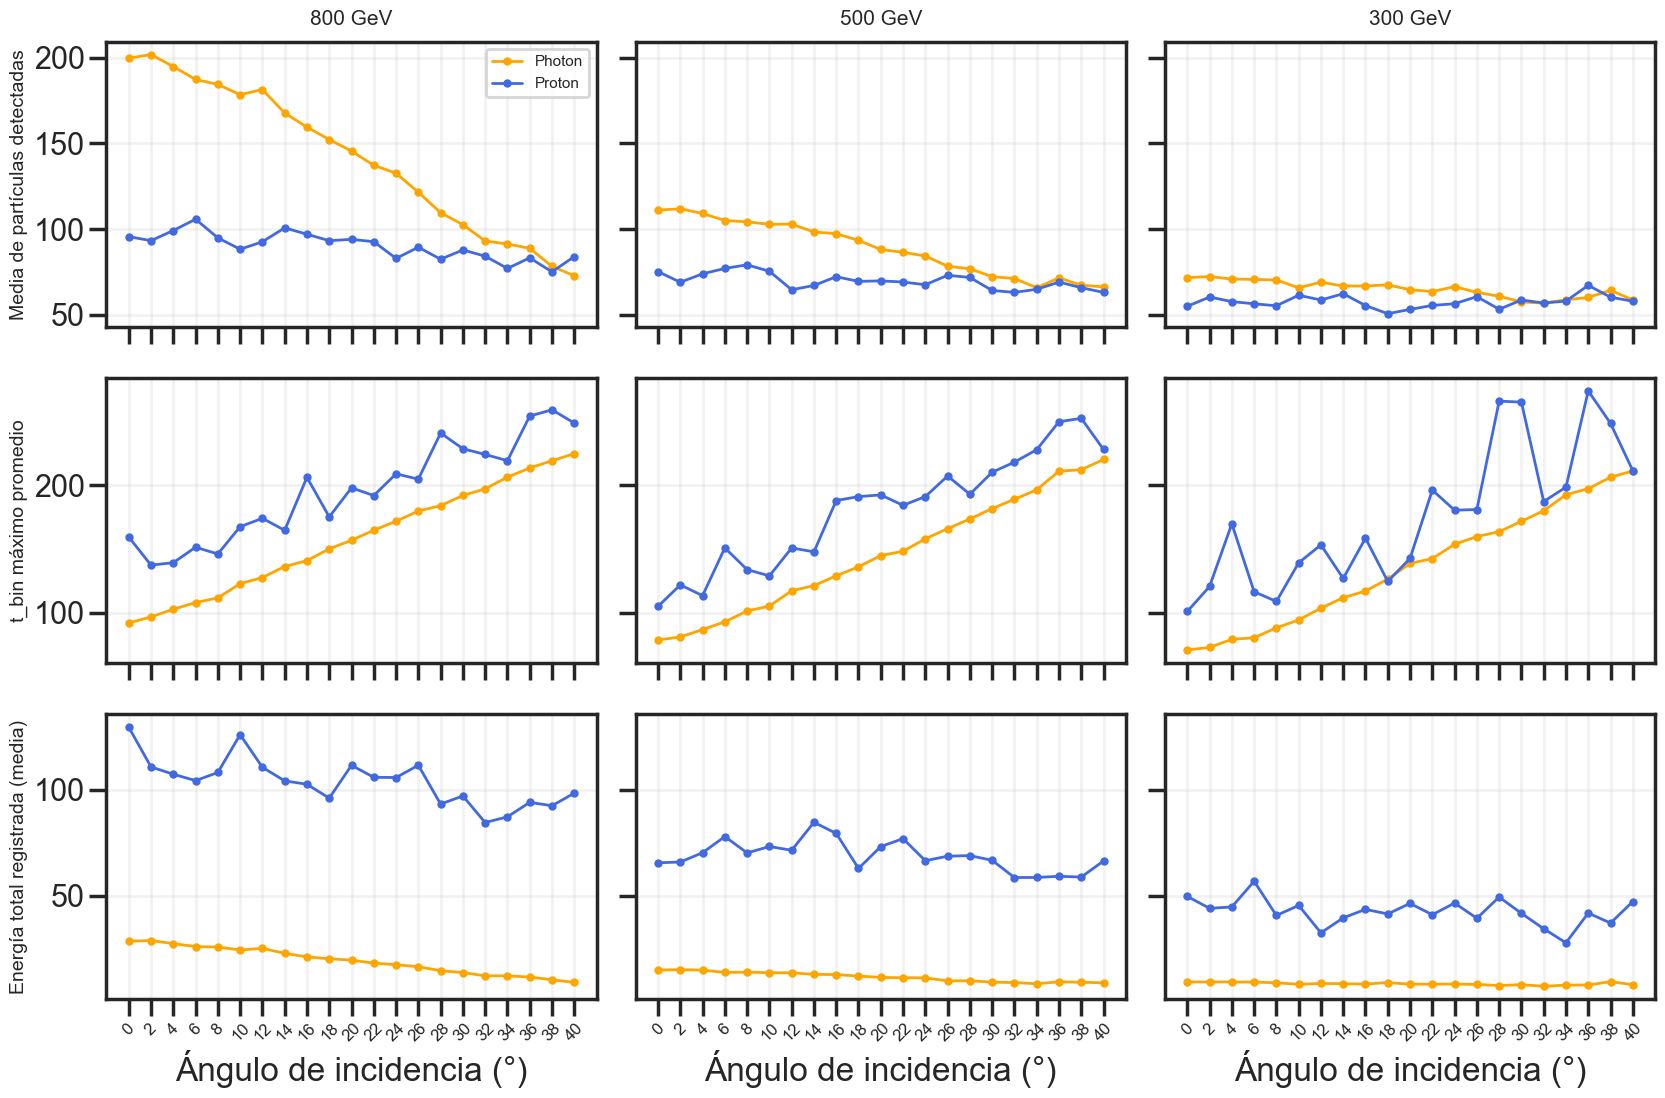

In [52]:
# ----------------------------- #
# Estadística por agrupaciones  #
# ----------------------------- #
def sequence_total_energy(seq: np.ndarray) -> float:
    arr = np.asarray(seq, dtype=np.float32)
    return float(arr[:, 7].sum()) if arr.ndim == 2 and arr.size else 0.0

if "total_energy_seq" not in df_filtered.columns:
    df_filtered["total_energy_seq"] = df_filtered["shower_data"].apply(sequence_total_energy)

energy_order = sorted(
    df_filtered["energy"].unique(),
    key=lambda x: float(x.replace("E", "e")),
    reverse=True,
)
energy_labels = {e: f"{float(e.replace('E', 'e')):,.0f} GeV" for e in energy_order}
angles = np.sort(df_filtered["angle"].unique())

metric_rows = [
    ("total_particles", "Media de partículas detectadas"),
    ("max_time", "t_bin máximo promedio"),
    ("total_energy_seq", "Energía total registrada (media)"),
]

nrows = len(metric_rows)
ncols = len(energy_order)

fig, axes = plt.subplots(
    nrows,
    ncols,
    figsize=(5.8 * ncols, 3.8 * nrows),
    sharex="col",
    sharey="row",
    constrained_layout=False,
)
plt.subplots_adjust(hspace=0.18, wspace=0.08, left=0.07, right=0.96, top=0.92, bottom=0.08)

if nrows == 1:
    axes = axes.reshape(1, -1)
if ncols == 1:
    axes = axes.reshape(-1, 1)

for col, energy in enumerate(energy_order):
    subset_energy = df_filtered[df_filtered["energy"] == energy]
    axes[0, col].set_title(energy_labels[energy], fontsize=15, pad=12)

    for row, (metric, ylabel) in enumerate(metric_rows):
        ax = axes[row, col]
        for particle, color in PARTICLE_COLORS.items():
            series = (
                subset_energy[subset_energy["particle"] == particle]
                .groupby("angle")[metric]
                .mean()
                .reindex(angles, fill_value=np.nan)
            )
            ax.plot(
                angles,
                series.values,
                marker="o",
                linewidth=2,
                markersize=5,
                label=particle,
                color=color,
            )

        if col == 0:
            ax.set_ylabel(ylabel, fontsize=14)
        if row == nrows - 1:
            ax.set_xlabel("Ángulo de incidencia (°)")
            ax.set_xticks(angles)
            ax.set_xticklabels([f"{a:.0f}" for a in angles], rotation=45, fontsize=12)
        else:
            ax.tick_params(axis="x", labelbottom=False)

        ax.grid(alpha=0.25)
        if col == 0 and row == 0:
            ax.legend(loc="upper right", fontsize=11)

plt.show()

In [32]:
# ----------------------------- #
# Resumen final                 #
# ----------------------------- #
summary = f"""
Eventos analizados: {len(df_filtered)}
Percentil 95 de longitud de secuencia: {np.percentile(seq_lengths, 95):.0f} pasos
Ángulos disponibles: {sorted(df_filtered['angle'].unique())}
Energías disponibles: {sorted(df_filtered['energy'].unique(), key=lambda x: float(x.replace('E','e')))}
"""
print(summary.strip())

Eventos analizados: 96988
Percentil 95 de longitud de secuencia: 223 pasos
Ángulos disponibles: [0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 22.0, 24.0, 26.0, 28.0, 30.0, 32.0, 34.0, 36.0, 38.0, 40.0]
Energías disponibles: ['3E2', '5E2', '8E2']


In [33]:
# ----------------------------- #
# Carga de artefactos persistidos
# ----------------------------- #
from pathlib import Path
import json

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    mean_absolute_error,
    root_mean_squared_error,
    r2_score,
)

# Usa la ruta ya definida en el notebook; si no existe, ajusta manualmente.
if "ARTIFACTS_DIR" not in globals():
    ARTIFACTS_DIR = Path(r"C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\CONDOR Angular Reconstruction\pipeline_artifacts")

MODEL_DIR = ARTIFACTS_DIR / "model"
history_csv = MODEL_DIR / "training_history.csv"
metrics_json = MODEL_DIR / "evaluation_metrics.json"
pred_npz = ARTIFACTS_DIR / "test_predictions.npz"
metadata_json = ARTIFACTS_DIR / "preprocessing_metadata.json"

history_df = pd.read_csv(history_csv)
with metrics_json.open("r", encoding="utf-8") as fh:
    stored_metrics = json.load(fh)

pred_file = np.load(pred_npz)
metadata = None
if metadata_json.exists():
    with metadata_json.open("r", encoding="utf-8") as fh:
        metadata = json.load(fh)

print(f"Artefactos cargados desde: {ARTIFACTS_DIR}")
if metadata:
    print(f"Conjunto de test: {metadata['train_val_test_split']['test']} eventos | Features secuenciales: {metadata['feature_order']}")

Artefactos cargados desde: C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\CONDOR_EAS-Reconstruction\pipeline_artifacts
Conjunto de test: 11209 eventos | Features secuenciales: ['detector_id', 'particle_count', 't_bin', 'total_energy', 'x_center', 'y_center']


In [34]:
# ----------------------------- #
# Reconstrucción de métricas y tablas
# ----------------------------- #
particle_prob = pred_file["particle_probability"].astype(float)
particle_pred = pred_file["particle_label_pred"].astype(int)
particle_true = pred_file["particle_label_true"].astype(int)

angle_pred = pred_file["angle_pred"].astype(float)
angle_true = pred_file["angle_true"].astype(float)

energy_pred = pred_file["energy_pred"].astype(float)
energy_true = pred_file["energy_true"].astype(float)

pred_summary = pd.DataFrame(
    {
        "particle_true": particle_true,
        "particle_pred_prob": particle_prob,
        "particle_pred_label": particle_pred,
        "angle_true_deg": angle_true,
        "angle_pred_deg": angle_pred,
        "energy_true_GeV": energy_true,
        "energy_pred_GeV": energy_pred,
        "energy_level_true": pred_file["energy_true_str"],
    }
)
pred_summary["angle_error_deg"] = pred_summary["angle_pred_deg"] - pred_summary["angle_true_deg"]
pred_summary["energy_error_GeV"] = pred_summary["energy_pred_GeV"] - pred_summary["energy_true_GeV"]
pred_summary["particle_correct"] = pred_summary["particle_true"] == pred_summary["particle_pred_label"]
pred_summary["angle_abs_error_deg"] = pred_summary["angle_error_deg"].abs()
pred_summary["energy_abs_error_GeV"] = pred_summary["energy_error_GeV"].abs()

angle_metrics = {
    "MAE (deg)": mean_absolute_error(angle_true, angle_pred),
    "RMSE (deg)": root_mean_squared_error(angle_true, angle_pred),
    "R2": r2_score(angle_true, angle_pred),
}
energy_metrics = {
    "MAE (GeV)": mean_absolute_error(energy_true, energy_pred),
    "RMSE (GeV)": root_mean_squared_error(energy_true, energy_pred),
    "R2": r2_score(energy_true, energy_pred),
}

print("Métricas almacenadas (evaluation_metrics.json):")
display(pd.DataFrame(stored_metrics["keras_metrics"], index=["value"]).T)
display(pd.DataFrame(stored_metrics["custom_metrics"], index=["value"]).T)

print("Métricas reconstruidas a partir de test_predictions.npz:")
display(pd.DataFrame(angle_metrics, index=["Ángulo"]).T.round(4))
display(pd.DataFrame(energy_metrics, index=["Energía"]).T.round(4))

Métricas almacenadas (evaluation_metrics.json):


,value
loss,0.669382
particle_output_loss,0.146299
angle_output_loss,0.229659
energy_output_loss,0.234629
particle_output_f1_score,0.969589
angle_output_mae,0.505213
energy_output_mae,0.502451


,value
particle_accuracy_custom,0.969667
angle_mae_deg_custom,0.505213
energy_mae_GeV_custom,103.251877
energy_rmse_GeV_custom,150.272614


Métricas reconstruidas a partir de test_predictions.npz:


,Ángulo
MAE (deg),0.5052
RMSE (deg),0.7536
R2,0.9961


,Energía
MAE (GeV),103.2519
RMSE (GeV),150.2726
R2,0.4639


### Performance metrics along training

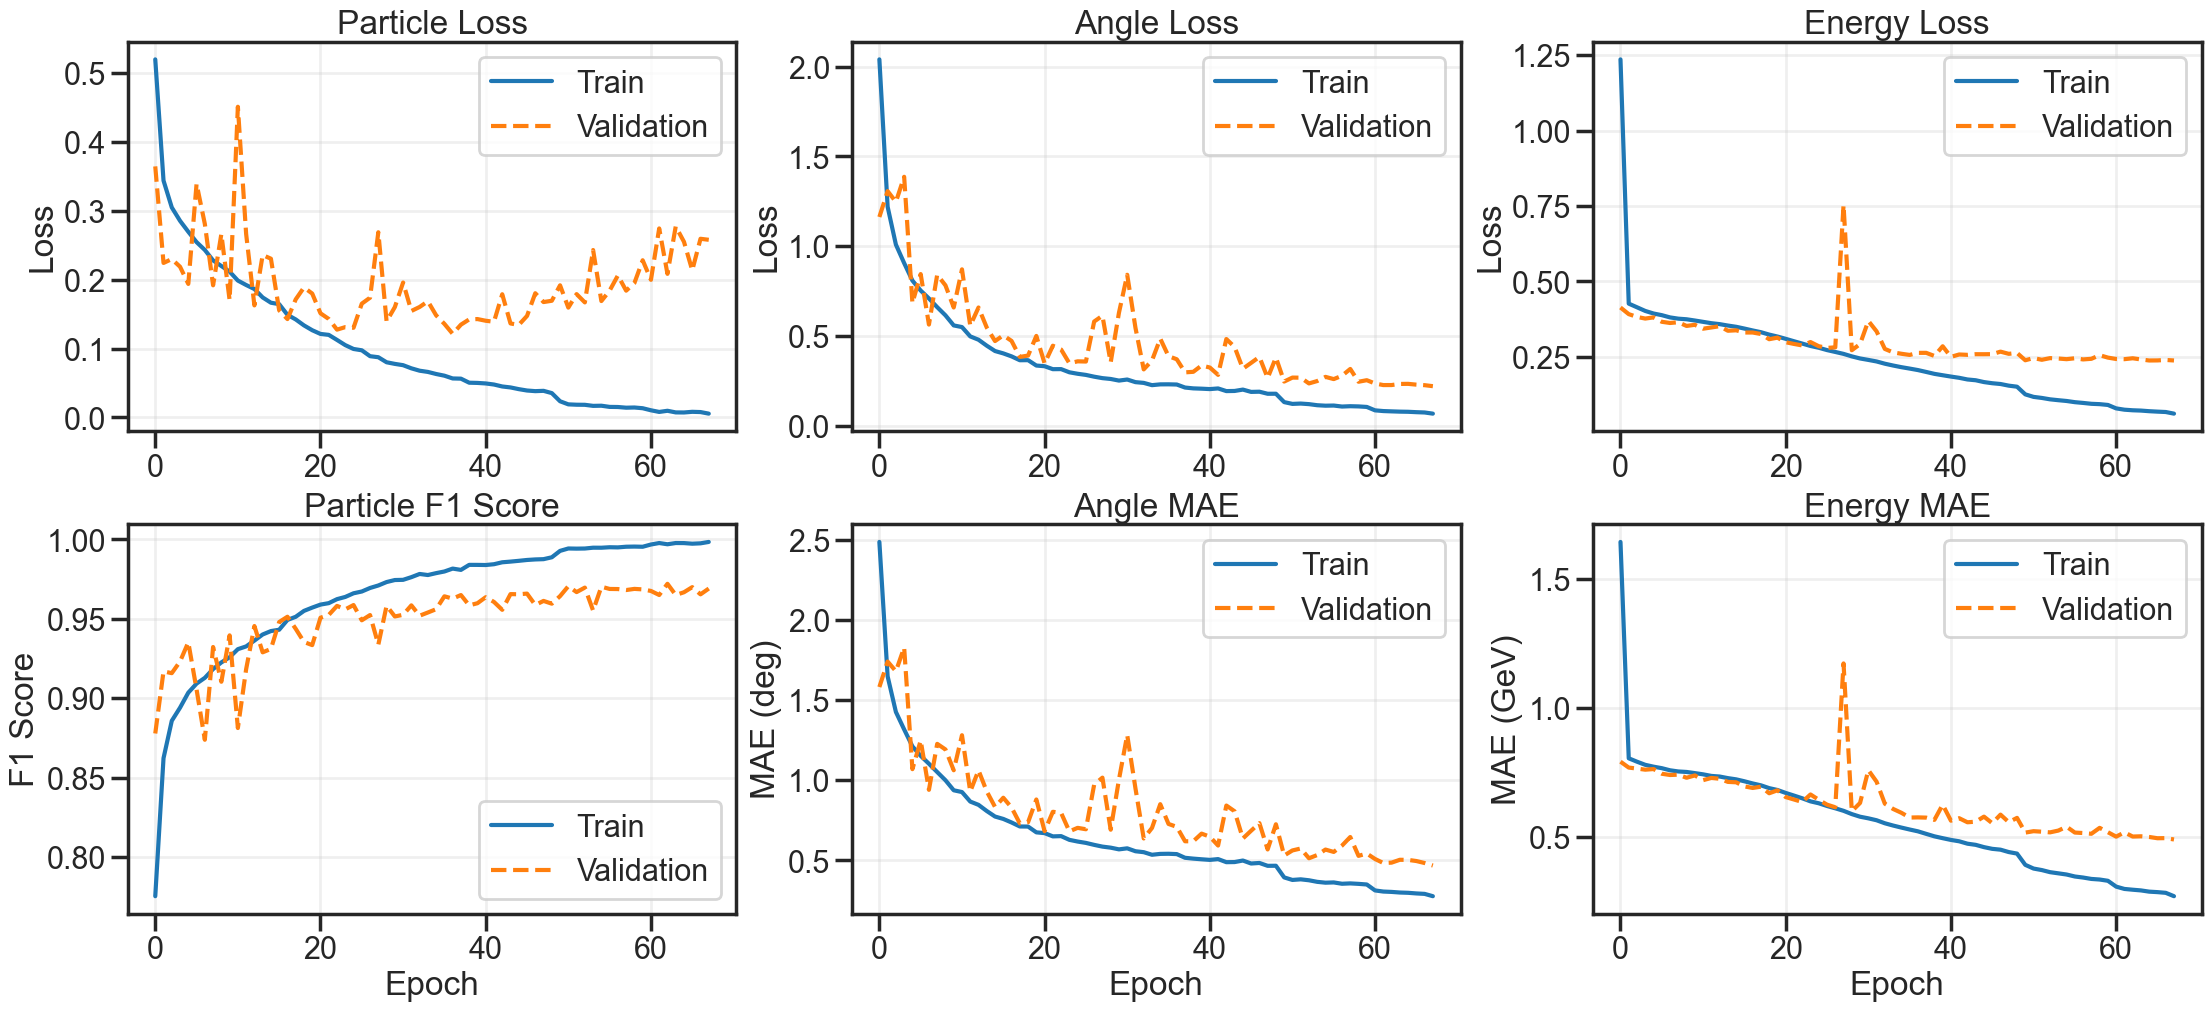

In [35]:
# Visualizaciones desde artefactos
# ----------------------------- #
plots_dir = ARTIFACTS_DIR / "diagnostics_artifacts"
plots_dir.mkdir(parents=True, exist_ok=True)

# Curvas de entrenamiento
fig, axes = plt.subplots(2, 3, figsize=(22, 10), constrained_layout=True)
for j, (col, title) in enumerate(zip(
    ["particle_output_loss", "angle_output_loss", "energy_output_loss"],
    ["Particle Loss", "Angle Loss", "Energy Loss"],
)):
    axes[0, j].plot(history_df[col], label="Train", color="tab:blue")
    axes[0, j].plot(history_df[f"val_{col}"], label="Validation", color="tab:orange", linestyle="--")
    axes[0, j].set_title(title)
    axes[0, j].set_ylabel("Loss")
    axes[0, j].grid(alpha=0.3)
    axes[0, j].legend()
    axes[1, j].set_xlabel("Epoch")

for j, (col, title, ylabel) in enumerate(zip(
    ["particle_output_f1_score", "angle_output_mae", "energy_output_mae"],
    ["Particle F1 Score", "Angle MAE", "Energy MAE"],
    ["F1 Score", "MAE (deg)", "MAE (GeV)"],
)):
    axes[1, j].plot(history_df[col], label="Train", color="tab:blue")
    axes[1, j].plot(history_df[f"val_{col}"], label="Validation", color="tab:orange", linestyle="--")
    axes[1, j].set_title(title)
    axes[1, j].set_ylabel(ylabel)
    axes[1, j].grid(alpha=0.3)
    axes[1, j].legend()

fig.savefig(plots_dir / "training_curves_artifacts.png", dpi=200)
plt.show()

### Gamma-Hadron Discrimination

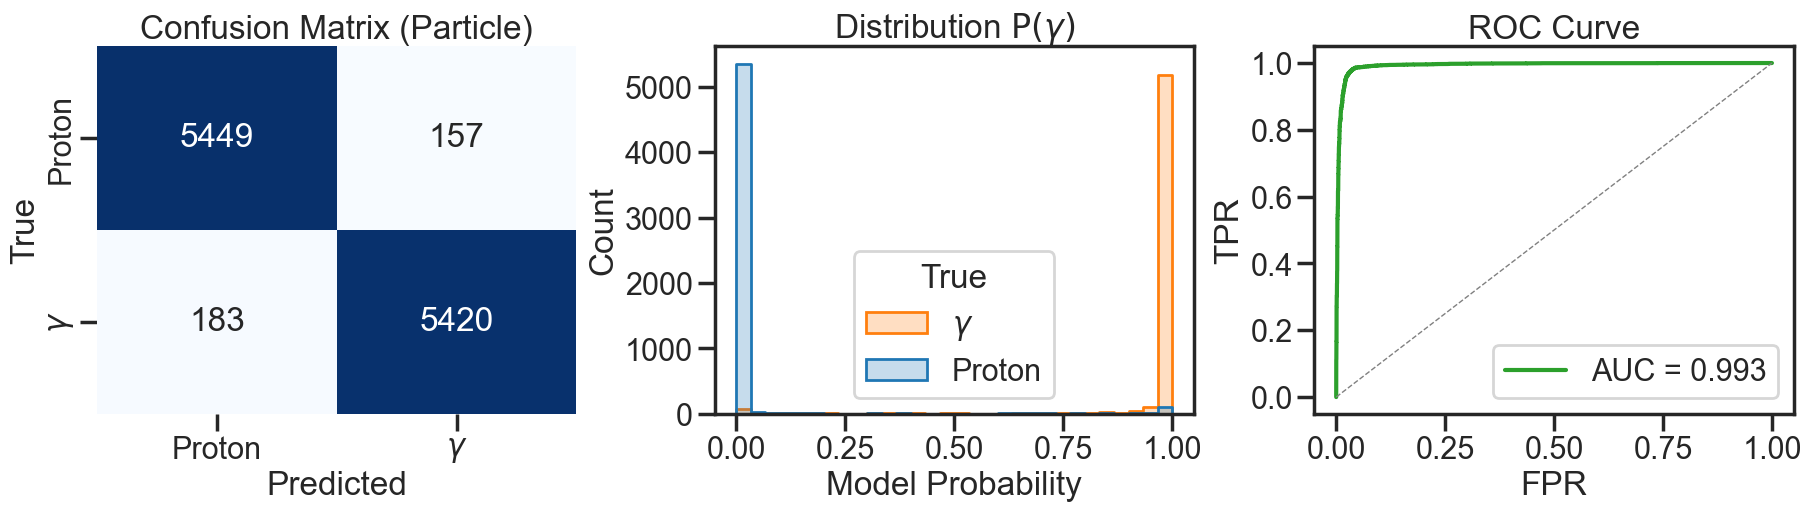

In [36]:
# Particle classification
cm_particle = confusion_matrix(pred_summary["particle_true"], pred_summary["particle_pred_label"])
particle_report = classification_report(
    pred_summary["particle_true"],
    pred_summary["particle_pred_label"],
    target_names=["Proton", "Photon"],
    output_dict=True,
)
fpr, tpr, _ = roc_curve(pred_summary["particle_true"], pred_summary["particle_pred_prob"])
roc_auc = auc(fpr, tpr)

fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)
sns.heatmap(cm_particle, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[0])
axes[0].set_title("Confusion Matrix (Particle)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")
axes[0].set_xticklabels(["Proton", r"$\gamma$"])
axes[0].set_yticklabels(["Proton", r"$\gamma$"])

sns.histplot(
    data=pred_summary,
    x="particle_pred_prob",
    hue="particle_true",
    bins=30,
    element="step",
    common_norm=False,
    palette={0: "tab:blue", 1: "tab:orange"},
    ax=axes[1],
)
axes[1].set_title(r"Distribution $\mathrm{P}(\gamma)$")
axes[1].set_xlabel("Model Probability")
axes[1].legend(title="True", labels=[r"$\gamma$", "Proton"])

axes[2].plot(fpr, tpr, color="tab:green", label=f"AUC = {roc_auc:.3f}")
axes[2].plot([0, 1], [0, 1], linestyle="--", color="gray", linewidth=1)
axes[2].set_title("ROC Curve")
axes[2].set_xlabel("FPR")
axes[2].set_ylabel("TPR")
axes[2].legend(loc="lower right")

fig.savefig(plots_dir / "particle_performance_artifacts.png", dpi=200)
plt.show()

### Zenith Angular Reconstruction

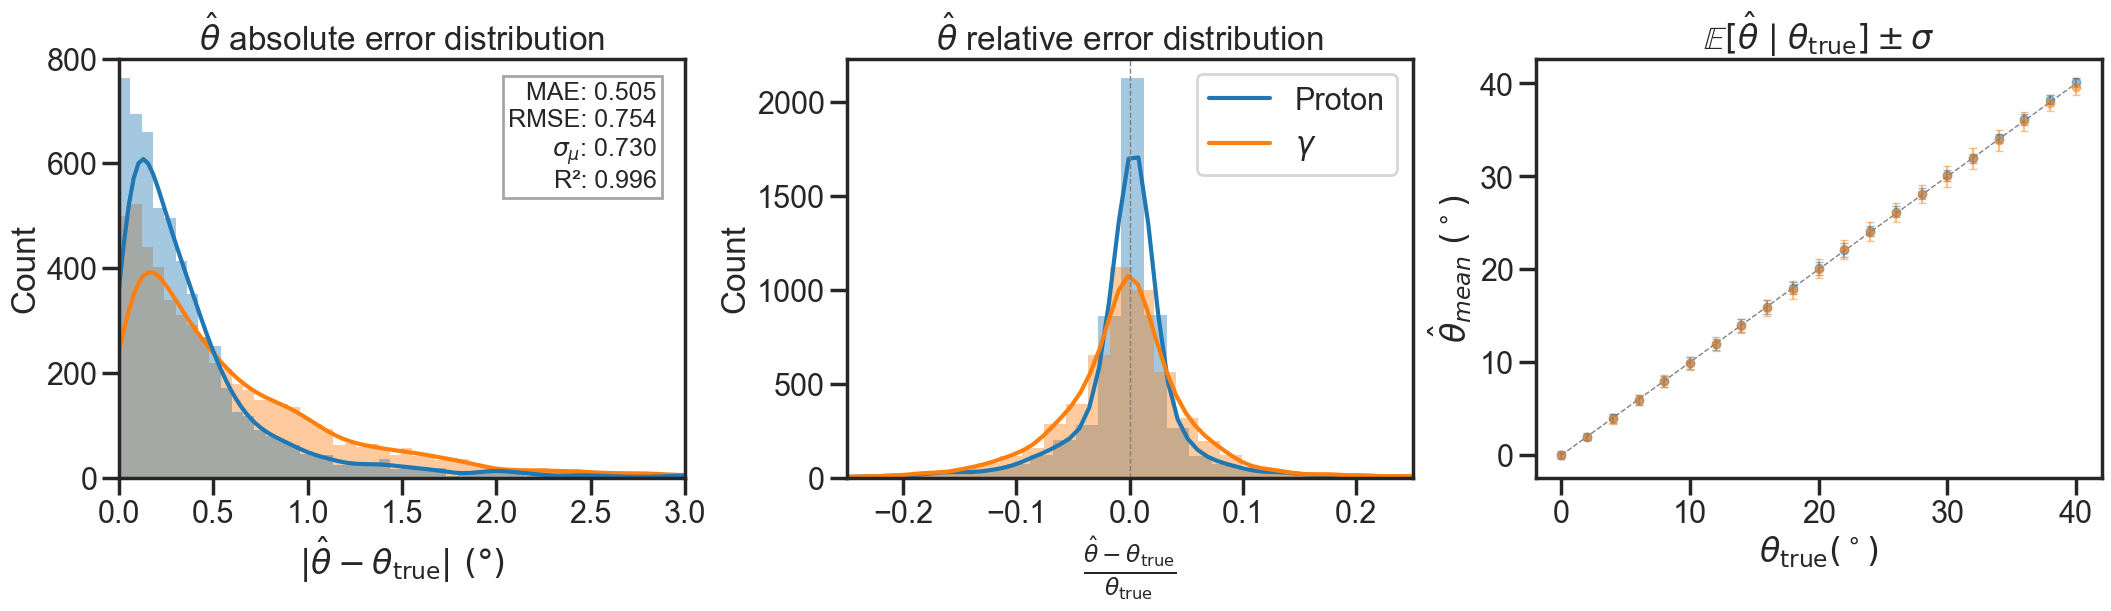

In [37]:
# ----------------------------- #
# Diagnóstico de ángulo y energía #
# ----------------------------- #
theta_hat = pred_summary["angle_pred_deg"]
theta_true = pred_summary["angle_true_deg"]
particle_series = pred_summary["particle_true"]

particle_names = {0: "Proton", 1: "Photon"}
particle_palette = {0: "tab:blue", 1: "tab:orange"}

denom = theta_true.replace(0.0, np.nan)
theta_rel_error = (theta_hat - theta_true) / denom
theta_rel_error = theta_rel_error.replace([np.inf, -np.inf], np.nan)

angle_bins = np.round(theta_true, 1)
angle_group = (
    pred_summary.assign(angle_bin=angle_bins)
    .groupby("angle_bin")
    .agg(mean_pred=("angle_pred_deg", "mean"), std_pred=("angle_pred_deg", "std"))
    .reset_index()
)
angle_group_particle = (
    pred_summary.assign(angle_bin=angle_bins)
    .groupby(["particle_true", "angle_bin"])
    .agg(mean_pred=("angle_pred_deg", "mean"), std_pred=("angle_pred_deg", "std"))
    .reset_index()
)

fig, axes = plt.subplots(1, 3, figsize=(21, 6), constrained_layout=True)

# Histograma del MAE de ángulo en axes[0]
sns.histplot(
    pred_summary,
    x="angle_abs_error_deg",
    hue="particle_true",
    bins=86,
    kde=True,
    ax=axes[0],
    edgecolor="none",
    alpha=0.4,
)
axes[0].set_xlabel(r"$|\hat{\theta} - \theta_{\mathrm{true}}|\ (°)$")
axes[0].set_title(r"$\hat{\theta}$ absolute error distribution")
axes[0].get_legend().remove()
axes[0].set_xlim(0, 3)

sigma_mu = angle_group["std_pred"].mean()
metrics_text = (
    f"MAE: {angle_metrics['MAE (deg)']:.3f}\n"
    f"RMSE: {angle_metrics['RMSE (deg)']:.3f}\n"
    f"$\\sigma_\\mu$: {sigma_mu:.3f}\n"
    f"R²: {angle_metrics['R2']:.3f}"
)
axes[0].text(
    0.95,
    0.68,
    metrics_text,
    transform=axes[0].transAxes,
    fontsize=18,
    verticalalignment="bottom",
    horizontalalignment="right",
    bbox=dict(facecolor="white", alpha=0.7, edgecolor="gray"),
)

for pid, color in particle_palette.items():
    mask = particle_series == pid
    sns.histplot(
        theta_rel_error[mask].dropna(),
        bins=86,
        kde=True,
        color=color,
        ax=axes[1],
        edgecolor="none",
        alpha=0.4,
        label=particle_names[pid],
    )
axes[1].axvline(0.0, color="gray", linestyle="--", linewidth=1)
axes[1].set_xlabel(r"$\frac{\hat{\theta}-\theta_{\mathrm{true}}}{\theta_{\mathrm{true}}}$")
axes[1].set_title(r"$\hat{\theta}$ relative error distribution")
axes[1].set_xlim(-0.25, 0.25)
axes[1].legend(labels=["Proton", r"$\gamma$"])

for pid, color in particle_palette.items():
    subset = angle_group_particle[angle_group_particle["particle_true"] == pid]
    axes[2].errorbar(
        subset["angle_bin"],
        subset["mean_pred"],
        yerr=subset["std_pred"].fillna(0.0),
        fmt=".",
        color=color,
        ecolor=color,
        elinewidth=1.5,
        alpha=0.5,
        capsize=3,
    )
axes[2].plot(
    angle_group["angle_bin"],
    angle_group["angle_bin"],
    color="gray",
    linestyle="--",
    linewidth=1,
)
axes[2].set_xlabel(r"$\theta_{\mathrm{true}}(^\circ)$")
axes[2].set_ylabel(r"$\hat{\theta}_{mean}\ (^\circ)$")
axes[2].set_title(r"$\mathbb{E}[\hat{\theta}\mid\theta_{\mathrm{true}}] \pm \sigma$")
fig.savefig(plots_dir / "angle_predictions_overview.png", dpi=200)
plt.show()

### Energy Estimation

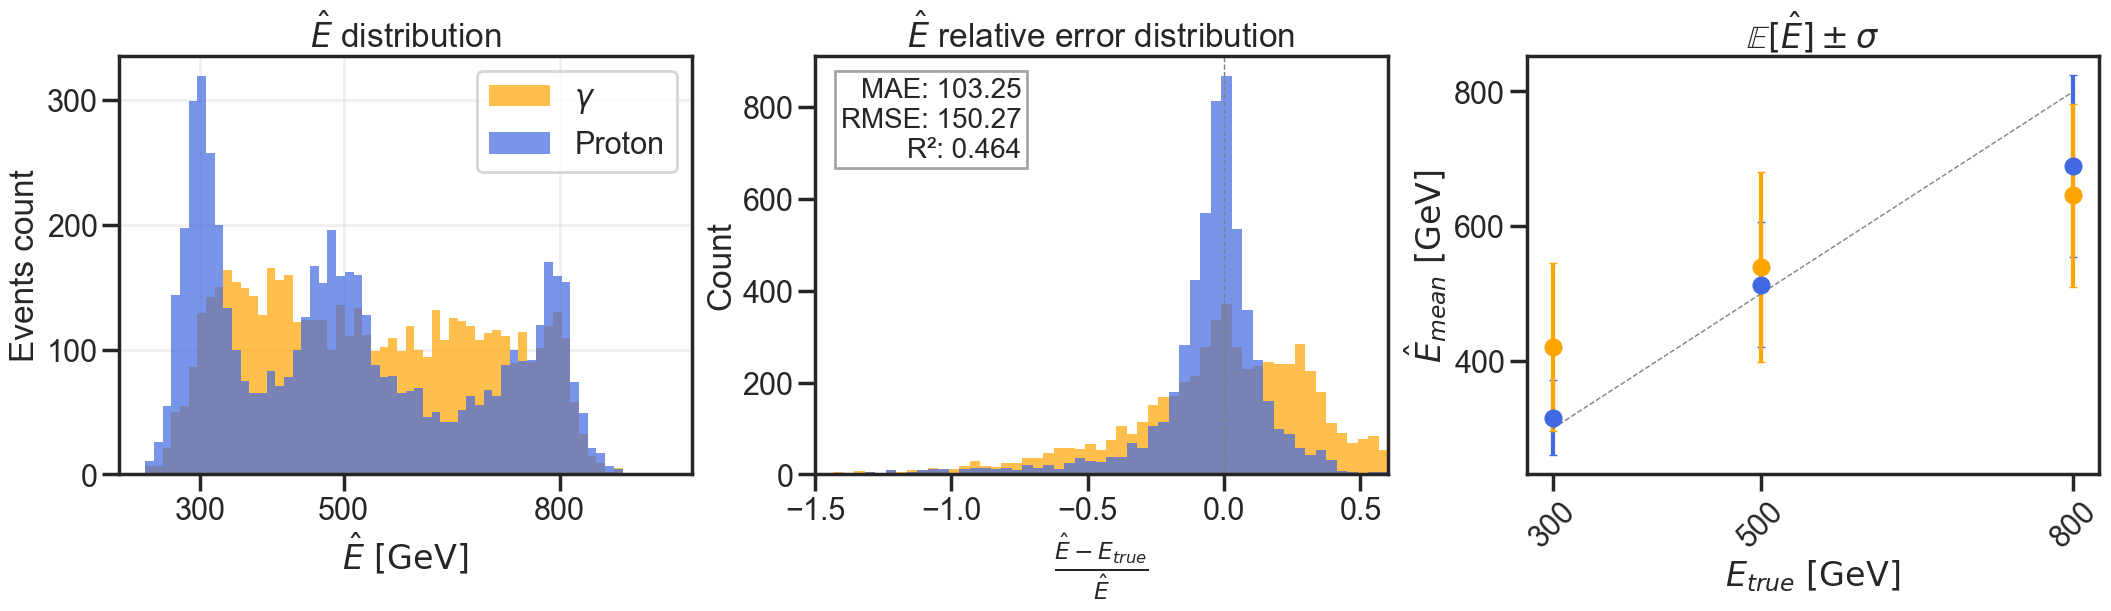

Visualizaciones guardadas en: C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\CONDOR_EAS-Reconstruction\pipeline_artifacts\diagnostics_artifacts


In [38]:
# Energía
E_true = pred_summary["energy_true_GeV"]
E_pred = pred_summary["energy_pred_GeV"]
E_rel_fraction = (E_pred - E_true) / pd.Series(E_pred).replace(0, np.nan)

fig, axes = plt.subplots(1, 3, figsize=(21, 6), constrained_layout=True)

# Histograma de energías predichas en axes[0] diferenciando por tipo de partícula
sns.histplot(
    data=pred_summary,
    x="energy_pred_GeV",
    hue="particle_true",
    bins=60,
    ax=axes[0],
    edgecolor="none",
    palette={0: "royalblue", 1: "orange"},  # 0=Proton, 1=Photon
    alpha=0.7,
    multiple="layer",
    hue_order=[0, 1],  # Fuerza el orden: 0=Proton, 1=Photon
)
axes[0].set_xlabel(r"$\hat{E} \ \mathrm{[GeV]}$")
axes[0].set_ylabel("Events count")
axes[0].set_title(r"$\hat{E}$ distribution")
axes[0].set_xticks([300, 500, 800])
axes[0].grid(alpha=0.3)
axes[0].legend(labels=[r"$\gamma$", "Proton"])
# Histograma del error relativo diferenciando por tipo de partícula
sns.histplot(
    data=pred_summary,
    x=E_rel_fraction,
    hue="particle_true",
    bins=80,
    ax=axes[1],
    edgecolor="none",
    palette={0: "royalblue", 1: "orange"},
    alpha=0.7,
    multiple="layer",
    hue_order=[0, 1],  # Fuerza el orden
)
axes[1].axvline(0.0, color="gray", linestyle="--", linewidth=1)
axes[1].set_xlabel(r"$\frac{\hat{E} - E_{true}}{\hat{E}}$")
axes[1].set_title(r"$\hat{E}$ relative error distribution")
axes[1].set_xlim(-1.5, 0.6)
axes[1].get_legend().remove()

# Mostrar métricas en el gráfico
energy_metrics = {
    "MAE (GeV)": mean_absolute_error(E_true, E_pred),
    "RMSE (GeV)": root_mean_squared_error(E_true, E_pred),
    "R2": r2_score(E_true, E_pred),
}
metrics_text = (
    f"MAE: {energy_metrics['MAE (GeV)']:.2f}\n"
    f"RMSE: {energy_metrics['RMSE (GeV)']:.2f}\n"
    f"R²: {energy_metrics['R2']:.3f}"
)
axes[1].text(
    0.36, 0.95, metrics_text,
    transform=axes[1].transAxes,
    fontsize=20,
    verticalalignment="top",
    horizontalalignment="right",
    bbox=dict(facecolor="white", alpha=0.7, edgecolor="gray")
)

# Gráfico de errorbar diferenciando por tipo de partícula
energy_group = (
    pred_summary.groupby(["energy_level_true", "particle_true"])
    .agg(
        mean_pred=("energy_pred_GeV", "mean"),
        std_pred=("energy_pred_GeV", "std"),
        true_energy=("energy_true_GeV", "mean"),
    )
    .reset_index()
    .sort_values("true_energy")
)

for particle in [0, 1]:
    subset = energy_group[energy_group["particle_true"] == particle]
    label = "Proton" if particle == 0 else "Photon"
    color = "royalblue" if particle == 0 else "orange"
    axes[2].errorbar(
        subset["true_energy"],
        subset["mean_pred"],
        yerr=subset["std_pred"].fillna(0.0),
        fmt="o",
        color=color,
        ecolor=color,
        capsize=3,
        label=label,
    )
axes[2].plot(energy_group["true_energy"].unique(), energy_group["true_energy"].unique(), color="gray", linestyle="--", linewidth=1)
axes[2].set_xlabel(r"$E_{true} \ \mathrm{[GeV]}$")
axes[2].set_ylabel(r"$\hat{E}_{mean} \ \mathrm{[GeV]}$")
axes[2].set_title(r"$\mathbb{E}[\hat{E}] \pm \sigma$")
axes[2].set_xticks(energy_group["true_energy"].unique())
axes[2].tick_params(axis="x", rotation=45)

fig.savefig(plots_dir / "energy_performance_artifacts.png", dpi=200)
plt.show()

print(f"Visualizaciones guardadas en: {plots_dir}")

In [39]:
energy_levels = sorted(E_true.unique())
resolution_stats = []

for E0 in energy_levels:
    mask = E_true == E0
    if not np.any(mask):
        continue
    abs_err = E_pred[mask] - E0
    rel_err = abs_err / E0
    sigma_68 = 0.5 * np.diff(np.percentile(rel_err, [16, 84]))[0]
    mae = np.mean(np.abs(abs_err))
    rmse = np.sqrt(np.mean(abs_err**2))
    resolution_stats.append(
        {
            "E_true_GeV": int(E0),
            "N": mask.sum(),
            "MAE": mae,
            "RMSE": rmse,
            "sigma_68": sigma_68,
        }
    )

for pid, label in zip([0, 1], ["Proton", "Photon"]):
    mask = pred_summary["particle_true"] == pid
    abs_err_pid = E_pred[mask] - E_true[mask]
    rel_err_pid = abs_err_pid / E_true[mask]
    sigma_68 = 0.5 * np.diff(np.percentile(rel_err_pid, [16, 84]))[0]
    mae = np.mean(np.abs(abs_err_pid))
    rmse = np.sqrt(np.mean(abs_err_pid**2))
    resolution_stats.append(
        {
            "E_true_GeV": label,
            "N": mask.sum(),
            "MAE": mae,
            "RMSE": rmse,
            "sigma_68": sigma_68,
        }
    )

df_resolution = pd.DataFrame(resolution_stats)

# Resultados globales
abs_err_global = E_pred - E_true
rel_err_global = abs_err_global / E_true
sigma_68_global = 0.5 * np.diff(np.percentile(rel_err_global, [16, 84]))[0]
mae_global = np.mean(np.abs(abs_err_global))
rmse_global = np.sqrt(np.mean(abs_err_global**2))

df_resolution = pd.concat([
    df_resolution,
    pd.DataFrame([{
        "E_true_GeV": "Global",
        "N": len(E_true),
        "MAE": mae_global,
        "RMSE": rmse_global,
        "sigma_68": sigma_68_global,
    }])
], ignore_index=True)

display(
    df_resolution.style.format(
        {
            "MAE": "{:.3f}",
            "RMSE": "{:.3f}",
            "sigma_68": "{:.3f}",
        }
    )
)

,E_true_GeV,N,MAE,RMSE,sigma_68
0,300,3758,78.922,129.030,0.273
1,500,3747,92.939,122.714,0.245
2,800,3704,138.369,190.294,0.180
3,Proton,5606,71.380,118.325,0.127
4,Photon,5603,135.140,176.543,0.338
5,Global,11209,103.252,150.273,0.236


In [40]:
# ----------------------------- #
# Reconstrucción de secuencias  #
# ----------------------------- #
from tensorflow.keras.preprocessing.sequence import pad_sequences

FEATURE_ORDER = [0, 2, 1, 7, 5, 6]
FEATURE_NAMES = ["detector_id", "particle_count", "t_bin", "total_energy", "x_center", "y_center"]

def build_sequence_list(shower_series: pd.Series) -> list[np.ndarray]:
    sequences = []
    for seq in shower_series:
        arr = np.asarray(seq, dtype=np.float32)
        if arr.size == 0:
            sequences.append(np.zeros((0, len(FEATURE_ORDER)), dtype=np.float32))
            continue
        order = np.argsort(arr[:, 1])
        ordered = arr[order][:, FEATURE_ORDER].astype(np.float32)
        sequences.append(ordered)
    return sequences

def compute_global_features(sequences: list[np.ndarray], central_ids: list[int]) -> np.ndarray:
    central_ids = np.array(central_ids, dtype=np.int32)
    feats = np.zeros((len(sequences), 5), dtype=np.float32)
    for idx, seq in enumerate(sequences):
        if seq.size == 0:
            continue
        det_ids = seq[:, 0].astype(np.int32)
        particle_counts = seq[:, 1]
        t_bins = seq[:, 2]
        tot_energy = seq[:, 3]

        total_particles = float(particle_counts.sum())
        total_energy = float(tot_energy.sum())
        active_detectors = float(np.unique(det_ids).size)
        duration = float(t_bins.max() - t_bins.min()) if len(t_bins) else 0.0
        mask_central = np.isin(det_ids, central_ids)
        energy_central = float(tot_energy[mask_central].sum()) if np.any(mask_central) else 0.0

        feats[idx] = [total_particles, total_energy, active_detectors, duration, energy_central]
    return feats

detector_catalog["distance"] = np.hypot(detector_catalog["x_center"], detector_catalog["y_center"])
central_ids = detector_catalog.nsmallest(16, "distance")["detector_id"].astype(int).tolist()

seq_list = build_sequence_list(df_filtered["shower_data"])
X_sequences = pad_sequences(seq_list, padding="post", dtype="float32")
X_global = compute_global_features(seq_list, central_ids)
y_particle = df_filtered["label"].to_numpy(dtype=np.int32)

print("Secuencias padded:", X_sequences.shape)
print("Features globales:", X_global.shape)

Secuencias padded: (96988, 540, 6)
Features globales: (96988, 5)


In [41]:
# ----------------------------- #
# Carga del modelo entrenado    #
# ----------------------------- #
from tensorflow.keras.metrics import Metric
from tensorflow.keras.models import load_model

class F1Score(Metric):
    def __init__(self, name="f1_score", threshold=0.5, **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.tp = self.add_weight(name="tp", initializer="zeros")
        self.fp = self.add_weight(name="fp", initializer="zeros")
        self.fn = self.add_weight(name="fn", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        tp = tf.reduce_sum(y_true * y_pred)
        fp = tf.reduce_sum((1 - y_true) * y_pred)
        fn = tf.reduce_sum(y_true * (1 - y_pred))
        self.tp.assign_add(tp)
        self.fp.assign_add(fp)
        self.fn.assign_add(fn)

    def result(self):
        precision = self.tp / (self.tp + self.fp + tf.keras.backend.epsilon())
        recall = self.tp / (self.tp + self.fn + tf.keras.backend.epsilon())
        return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

    def reset_state(self):
        self.tp.assign(0)
        self.fp.assign(0)
        self.fn.assign(0)

model_path = ARTIFACTS_DIR / "model" / "condor_multitask_model.keras"
loaded_model = load_model(model_path, custom_objects={"F1Score": F1Score})
print("Modelo cargado desde:", model_path)

Modelo cargado desde: C:\Users\Froxo\OneDrive - Universidad Técnica Federico Santa María\CONDOR\CONDOR_EAS-Reconstruction\pipeline_artifacts\model\condor_multitask_model.keras


In [42]:
# ----------------------------- #
# Permutation Feature Importance #
# ----------------------------- #
from sklearn.metrics import roc_auc_score

GLOBAL_FEATURE_NAMES = [
    "sum_particle_count",
    "sum_total_energy",
    "num_active_detectors",
    "duration_tbin",
    "sum_energy_central_ids",
]

subset = min(1024, len(X_sequences))
subset_idx = np.random.choice(len(X_sequences), size=subset, replace=False)
X_seq_subset = X_sequences[subset_idx]
Xg_subset = X_global[subset_idx]
y_subset = y_particle[subset_idx]

baseline_probs = loaded_model.predict([X_seq_subset, Xg_subset], verbose=0)[0].reshape(-1)
baseline_auc = roc_auc_score(y_subset, baseline_probs)
print(f"AUC base (partícula): {baseline_auc:.4f}")

n_repeats = 5
importance_scores = {}

for j, name in enumerate(GLOBAL_FEATURE_NAMES):
    drops = []
    for _ in range(n_repeats):
        Xg_perm = Xg_subset.copy()
        np.random.shuffle(Xg_perm[:, j])
        perm_probs = loaded_model.predict([X_seq_subset, Xg_perm], verbose=0)[0].reshape(-1)
        drops.append(baseline_auc - roc_auc_score(y_subset, perm_probs))
    importance_scores[name] = np.mean(drops)

imp_df = (
    pd.Series(importance_scores, name="AUC drop")
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={"index": "Feature"})
)

plt.figure(figsize=(7, 4))
sns.barplot(data=imp_df, x="AUC drop", y="Feature", palette="magma")
plt.title("Permutation Importance – Global features (particle output)")
plt.xlabel("Δ AUC al permutar")
plt.ylabel("")
plt.tight_layout()
plt.show()

ValueError: in user code:

    File "c:\Users\Froxo\.conda\envs\ML_Condor\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\Froxo\.conda\envs\ML_Condor\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Froxo\.conda\envs\ML_Condor\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\Froxo\.conda\envs\ML_Condor\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "c:\Users\Froxo\.conda\envs\ML_Condor\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\Froxo\.conda\envs\ML_Condor\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "CONDOR_Multitask" is incompatible with the layer: expected shape=(None, 472, 6), found shape=(32, 540, 6)
